In [1]:
import pandas as pd # working with dataframes
import missingno #package to find and display na
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf#used for fitting models
import matplotlib.pyplot as plt
from plotnine import *
import stepwise as stepwise#make sure this file is located in the same folder as this script
from sklearn.metrics import roc_curve #AUC info
from sklearn.metrics import roc_auc_score# AUC score
from sklearn.metrics import accuracy_score #accuracy performance measure
from sklearn.metrics import recall_score# sensitivity performance measure
from sklearn.metrics import precision_score# precision performance measure
from sklearn.metrics import confusion_matrix# confusion matrix
from mizani.formatters import percent_format #to have % on axis in plotnine
import sys #maxsize
import seaborn as sns# heatmap
import datetime# working with dates
from sklearn.model_selection import train_test_split
import plotnine as pn

In [2]:
def forwardSelection(X, y, model_type ="linear",elimination_criteria = "aic", varchar_process = "dummy_dropfirst", sl=0.05):
    """
    Forward Selection is a function, based on regression models, that returns significant features and selection iterations.\n
    Required Libraries: pandas, numpy, statmodels
    
    Parameters
    ----------
    X : Independent variables (Pandas Dataframe)\n
    y : Dependent variable (Pandas Series, Pandas Dataframe)\n
    model_type : 'linear' or 'logistic'\n
    elimination_criteria : 'aic', 'bic', 'r2', 'adjr2' or None\n
        'aic' refers Akaike information criterion\n
        'bic' refers Bayesian information criterion\n
        'r2' refers R-squared (Only works on linear model type)\n
        'r2' refers Adjusted R-squared (Only works on linear model type)\n
    varchar_process : 'drop', 'dummy' or 'dummy_dropfirst'\n
        'drop' drops varchar features\n
        'dummy' creates dummies for all levels of all varchars\n
        'dummy_dropfirst' creates dummies for all levels of all varchars, and drops first levels\n
    sl : Significance Level (default: 0.05)\n
    

    Returns
    -------
    columns(list), iteration_logs(str)\n\n
    Not Returns a Model
    

    Tested On
    ---------
    Python v3.6.7, Pandas v0.23.4, Numpy v1.15.04, StatModels v0.9.0
    

    See Also
    --------
    https://en.wikipedia.org/wiki/Stepwise_regression
    """
    X = __varcharProcessing__(X,varchar_process = varchar_process)
    return __forwardSelectionRaw__(X, y, model_type = model_type,elimination_criteria = elimination_criteria , sl=sl)

def __varcharProcessing__(X, varchar_process = "dummy_dropfirst"):
    
    dtypes = X.dtypes
    if varchar_process == "drop":   
        X = X.drop(columns = dtypes[dtypes == object].index.tolist())
        #print("Character Variables (Dropped):", dtypes[dtypes == np.object].index.tolist())
    elif varchar_process == "dummy":
        X = pd.get_dummies(X,drop_first=False)
        #print("Character Variables (Dummies Generated):", dtypes[dtypes == np.object].index.tolist())
    elif varchar_process == "dummy_dropfirst":
        X = pd.get_dummies(X,drop_first=True)
        #print("Character Variables (Dummies Generated, First Dummies Dropped):", dtypes[dtypes == np.object].index.tolist())
    else: 
        X = pd.get_dummies(X,drop_first=True)
        #print("Character Variables (Dummies Generated, First Dummies Dropped):", dtypes[dtypes == np.object].index.tolist())
    
    X["intercept"] = 1
    cols = X.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    X = X[cols]
    
    return X

def __forwardSelectionRaw__(X, y, model_type ="linear",elimination_criteria = "aic", sl=0.05):

    iterations_log = ""
    cols = X.columns.tolist()
    
    def regressor(y,X, model_type=model_type):
        if model_type == "linear":
            regressor = sm.OLS(y, X).fit()
        elif model_type == "logistic":
            regressor = sm.Logit(y, X).fit()
        else:
            print("\nWrong Model Type : "+ model_type +"\nLinear model type is seleted.")
            model_type = "linear"
            regressor = sm.OLS(y, X).fit()
        return regressor
    
    selected_cols = ["intercept"]
    other_cols = cols.copy()
    other_cols.remove("intercept")
    
    model = regressor(y, X[selected_cols])
    
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj
    
    
    for i in range(X.shape[1]):
        pvals = pd.DataFrame(columns = ["Cols","Pval"])
        for j in other_cols:
            model = regressor(y, X[selected_cols+[j]])
            pvals = pvals.append(pd.DataFrame([[j, model.pvalues[j]]],columns = ["Cols","Pval"]),ignore_index=True)
        pvals = pvals.sort_values(by = ["Pval"]).reset_index(drop=True)
        pvals = pvals[pvals.Pval<=sl]
        if pvals.shape[0] > 0:
            
            model = regressor(y, X[selected_cols+[pvals["Cols"][0]]])
            iterations_log += str("\nEntered : "+pvals["Cols"][0] + "\n")    
            iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"
                    
        
            if  elimination_criteria == "aic":
                new_criteria = model.aic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tAIC :", model.aic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break
            elif  elimination_criteria == "bic":
                new_criteria = model.bic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tBIC :", model.bic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break        
            elif  elimination_criteria == "r2" and model_type =="linear":
                new_criteria = model.rsquared
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tR2 :", model.rsquared)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break           
            elif  elimination_criteria == "adjr2" and model_type =="linear":
                new_criteria = model.rsquared_adj
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tAdjR2 :", model.rsquared_adj)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("Break : Criteria")
                    break
            else:
                print("Entered :", pvals["Cols"][0])
                selected_cols.append(pvals["Cols"][0])
                other_cols.remove(pvals["Cols"][0])            
                
        else:
            print("Break : Significance Level")
            break
        
    model = regressor(y, X[selected_cols])
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj
    
    print(model.summary())
    print("AIC: "+str(model.aic))
    print("BIC: "+str(model.bic))
    print("Final Variables:", selected_cols)

    return selected_cols, iterations_log,model


In [3]:
#Read in dataframes
summerfintrx = pd.read_csv('summerfintrx.csv',parse_dates=['Date'])
summersesstrx = pd.read_csv('summersesstrx.csv',parse_dates=['Date'])
fallfintrx = pd.read_csv('fallfintrx.csv',parse_dates=['Date'])
fallsesstrx = pd.read_csv('fallsesstrx.csv',parse_dates=['Date'])
customerdata = pd.read_csv('customerdata.csv',parse_dates=['Registrationdate'])

In [4]:
#convert datetime to date (we don't need the hour)
summerfintrx['Date'] = pd.to_datetime(summerfintrx['Date'])
summersesstrx['Date'] = pd.to_datetime(summersesstrx['Date'])
fallfintrx['Date'] = pd.to_datetime(fallfintrx['Date'])
fallsesstrx['Date'] = pd.to_datetime(fallsesstrx['Date'])
customerdata['Registrationdate'] = pd.to_datetime(customerdata['Registrationdate'])

In [5]:
summerfintrx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2250 entries, 0 to 2249
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   TransID     2250 non-null   int64         
 1   Date        2250 non-null   datetime64[ns]
 2   CustomerID  2250 non-null   int64         
 3   ProductID   2250 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 70.4 KB


In [6]:
summersesstrx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20103 entries, 0 to 20102
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   PlayID      20103 non-null  int64         
 1   Date        20103 non-null  datetime64[ns]
 2   CustomerID  20103 non-null  int64         
 3   Experience  20103 non-null  int64         
 4   Pokestops   20103 non-null  int64         
 5   Gyms        20103 non-null  int64         
 6   Raids       20103 non-null  int64         
 7   Social      20103 non-null  int64         
 8   Pokemon     20103 non-null  int64         
 9   Distance    20103 non-null  float64       
 10  Duration    20103 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(8)
memory usage: 1.7 MB


In [7]:
customerdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        5000 non-null   int64         
 1   CustomerType      5000 non-null   int64         
 2   Registrationdate  5000 non-null   datetime64[ns]
 3   Gender            5000 non-null   int64         
 4   Age               5000 non-null   int64         
 5   fallbonus         5000 non-null   int64         
 6   Income            5000 non-null   int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 273.6 KB


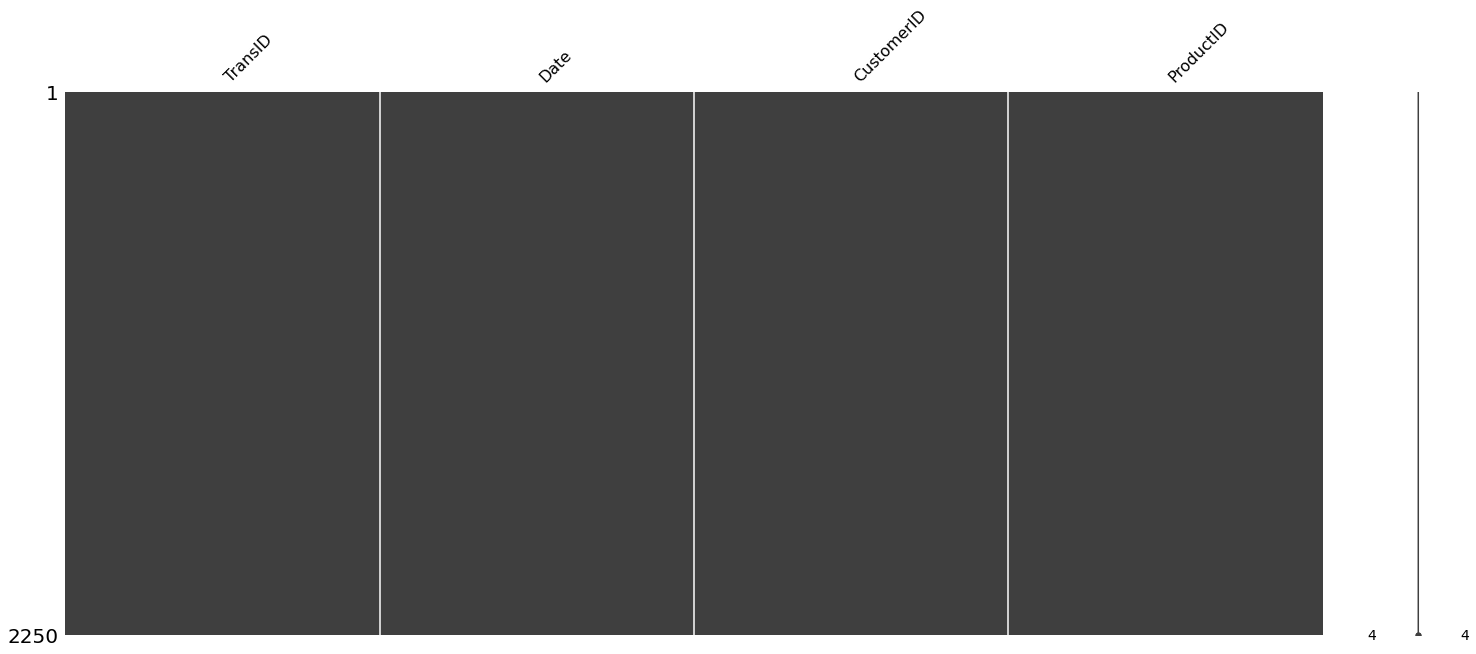

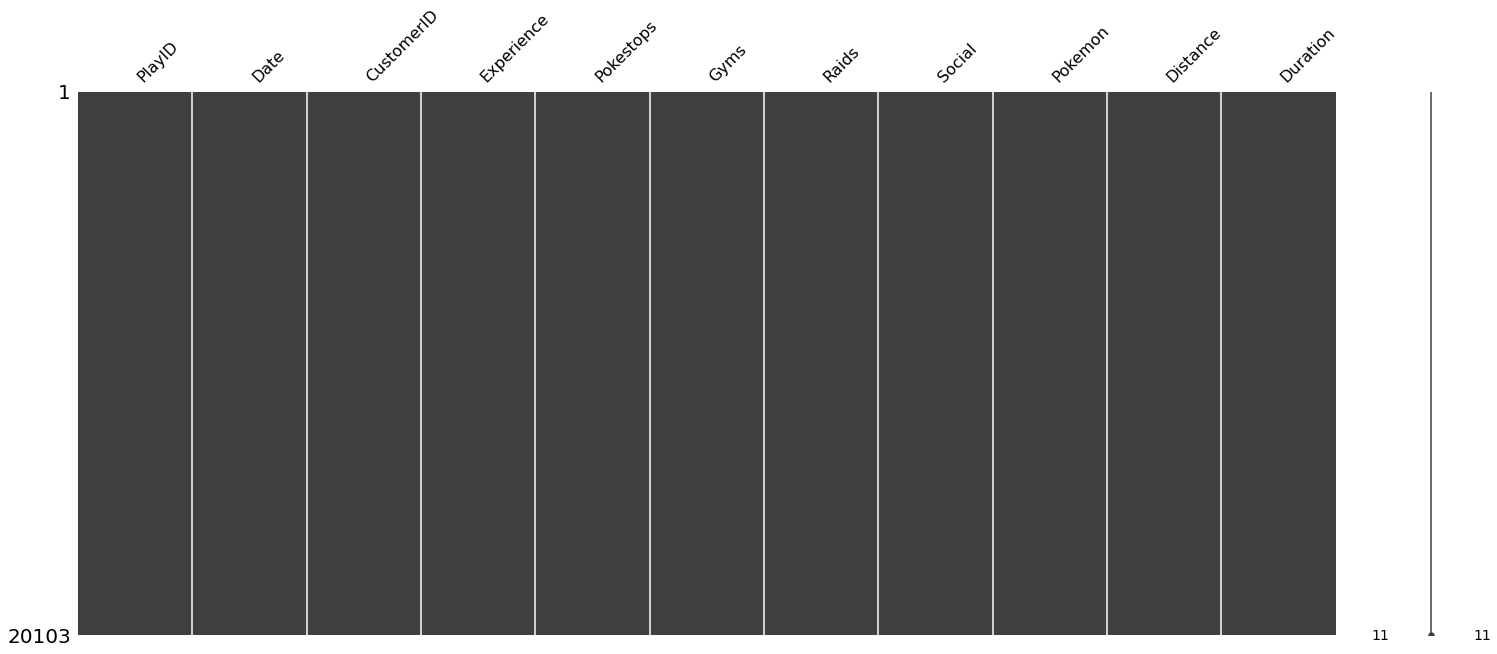

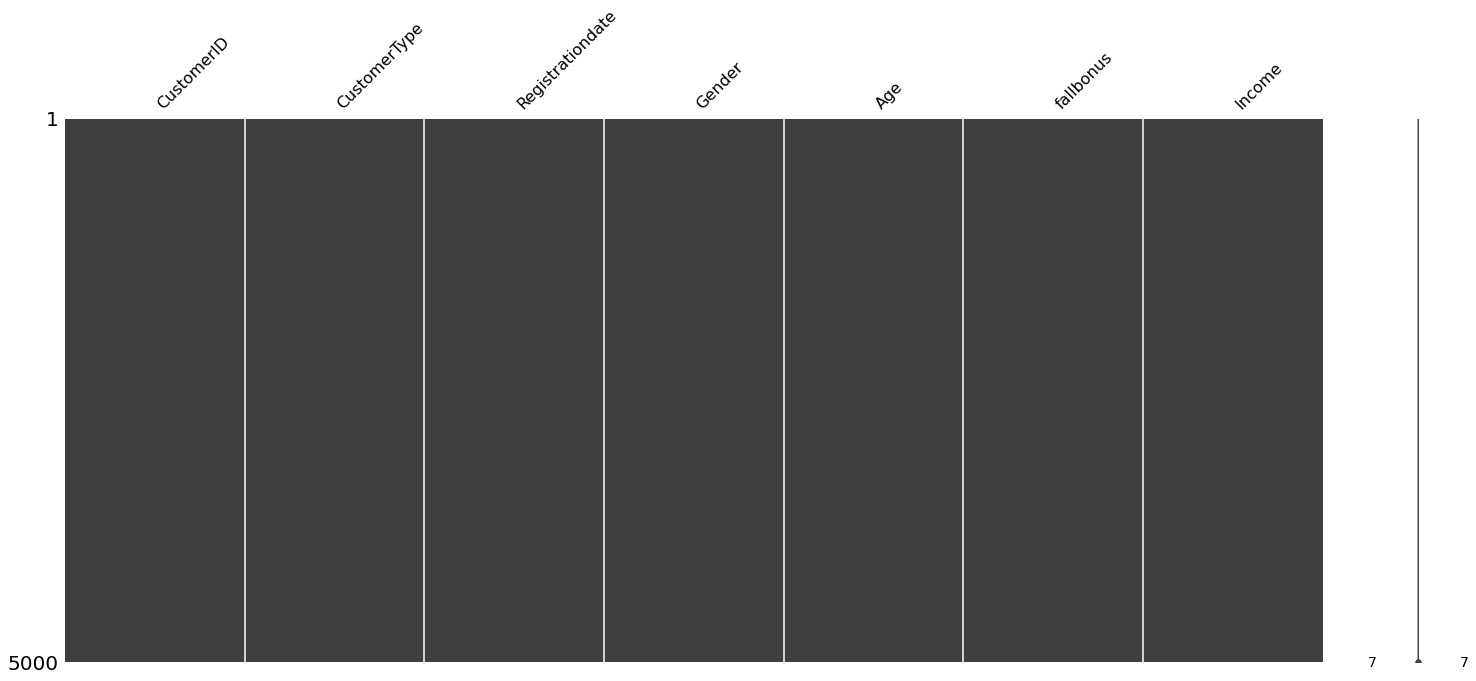

In [8]:
#check for missing values
missingno.matrix(summerfintrx)
plt.show()
missingno.matrix(summersesstrx)
plt.show()
missingno.matrix(customerdata)
plt.show()

In [9]:
#In Question 1 we are searching for active players in summer period
summeractive=summersesstrx.groupby('CustomerID').agg({'CustomerID':'count'})
summeractive.columns=['nbrsesstrx']

In [10]:
#all active customers information during the summer period 
summer = summeractive.merge(customerdata, how='left', left_on='CustomerID', right_on='CustomerID')
summer

,CustomerID,nbrsesstrx,CustomerType,Registrationdate,Gender,Age,fallbonus,Income
0,1,3,4,2021-09-30,1,8,0,1
1,2,1,4,2022-04-06,1,27,0,1
2,3,3,3,2020-05-24,0,7,0,2
3,4,4,4,2021-09-21,0,11,0,2
4,5,1,4,2021-07-08,1,16,1,1
...,...,...,...,...,...,...,...,...
4698,4996,3,1,2022-03-18,0,42,0,3
4699,4997,1,4,2022-04-02,1,30,1,2
4700,4998,9,3,2022-03-11,1,9,0,3
4701,4999,10,3,2022-04-28,0,30,1,2


In [11]:
#4703 active customers during the summer period of all 5000 customers
activerate = 4703/5000*100
print(activerate)

94.06


In [12]:
#Distribution of gender
female_customers = summer[summer['Gender'] == 1]
female_customers.count()
femalerate = 1856/4703*100

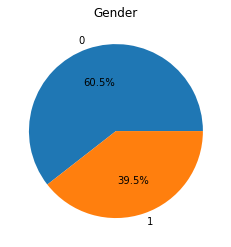

In [13]:
#Pie chart of customers type of all active customers during the summer period
gender = summer.groupby('Gender').size()
fig, ax = plt.subplots()
ax.pie(gender.values, labels=gender.index, autopct='%1.1f%%')
ax.set_title('Gender')

plt.show()
#40% female, 60%male 

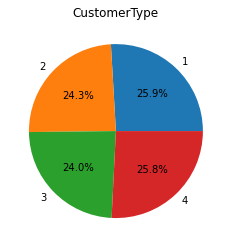

In [14]:
#Pie chart of customers type of all active customers during the summer period
ct = summer.groupby('CustomerType').size()
fig, ax = plt.subplots()
ax.pie(ct.values, labels=ct.index, autopct='%1.1f%%')
ax.set_title('CustomerType')

plt.show()

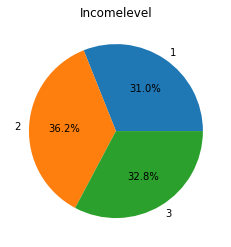

In [15]:
#Disribution of income level
income = summer.groupby('Income').size()
fig, ax = plt.subplots()
ax.pie(income.values, labels=income.index, autopct='%1.1f%%')
ax.set_title('Incomelevel')

plt.show()

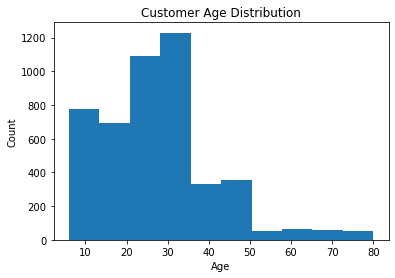

In [16]:
#Distribution of age
plt.hist(summer['Age'], bins=10)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Customer Age Distribution')
plt.show()

In [17]:
summer['Age'].describe()

count    4703.000000
mean       27.642994
std        13.666188
min         6.000000
25%        17.500000
50%        27.000000
75%        34.000000
max        80.000000
Name: Age, dtype: float64

In [18]:
#average age of customers is 27.6, min 6 max 80, most of customers are younger than 30

In [19]:
#Calculate RFM metrics
starttime=datetime.datetime.strptime('01/05/2022','%d/%m/%Y')
endtime=datetime.datetime.strptime('31/08/2022','%d/%m/%Y')

In [20]:
basetable=summersesstrx.groupby('CustomerID').agg({'CustomerID':'count',
                                         'Date':lambda date: (endtime - date.max()).days
                                         })

In [21]:
basetable.columns=['frequency','recency']
basetable

,frequency,recency
CustomerID,,
1,3,35
2,1,54
3,3,25
4,4,7
5,1,44
...,...,...
4996,3,0
4997,1,31
4998,9,20


In [22]:
#find purchase amount of customers
def func(x):
    if x == 1:
        return 2.99
    elif x == 2:
        return 4.99
    elif x == 3:
        return 9.99
    elif x == 4:
        return 25
    elif x == 5:
        return 99
    else:
        return 'N/A'

In [23]:
summerfintrx['PurchaseAmount'] = summerfintrx['ProductID'].apply(func)
summerfintrx
#2250 microtransactions during the summer period 

,TransID,Date,CustomerID,ProductID,PurchaseAmount
0,1,2022-05-01,4147,2,4.99
1,2,2022-05-01,3065,2,4.99
2,3,2022-05-01,4078,1,2.99
3,4,2022-05-01,4850,1,2.99
4,5,2022-05-01,4806,4,25.00
...,...,...,...,...,...
2245,2246,2022-08-31,4774,3,9.99
2246,2247,2022-08-31,3909,4,25.00
2247,2248,2022-08-31,1508,3,9.99
2248,2249,2022-08-31,3484,1,2.99


In [24]:
summerfintrx['PurchaseAmount'].describe()

count    2250.000000
mean        8.351684
std        11.735460
min         2.990000
25%         2.990000
50%         4.990000
75%         9.990000
max        99.000000
Name: PurchaseAmount, dtype: float64

In [25]:
customer_products = summerfintrx.groupby('CustomerID')['ProductID'].agg(list)
customer_products

CustomerID
5       [2, 2, 3]
9             [2]
10            [2]
17            [2]
20            [1]
          ...    
4988          [1]
4989          [2]
4997          [3]
4998          [2]
5000          [2]
Name: ProductID, Length: 1711, dtype: object

In [26]:
#onetime buyers = 1269
#Among those purchased customers，74% are one-time buyers.
#37.5% buyers start to purchase from product 1 

In [27]:
#Distribution of productid among those transactions 
grouped_summerfintrx = summerfintrx.groupby('ProductID').size()

In [28]:
grouped_summerfintrx

ProductID
1    847
2    759
3    365
4    254
5     25
dtype: int64

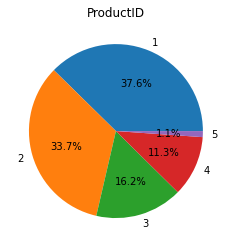

In [29]:
fig, ax = plt.subplots()
ax.pie(grouped_summerfintrx.values, labels=grouped_summerfintrx.index, autopct='%1.1f%%')
ax.set_title('ProductID')

plt.show()

In [30]:
monetaryvalue=summerfintrx.groupby('CustomerID').agg({'PurchaseAmount': 'sum'})

In [31]:
monetaryvalue.columns=['monetaryvalue']
monetaryvalue

,monetaryvalue
CustomerID,
5,19.97
9,4.99
10,4.99
17,4.99
20,2.99
...,...
4988,2.99
4989,4.99
4997,9.99


In [32]:
#1711 customers actually paid for products in the game among 4703 active customers in the summer period 
paymentrate = 1711/4703*100
print(paymentrate)

36.38103338294705


In [33]:
monetaryvalue.describe()

,monetaryvalue
count,1711.000000
mean,10.982636
std,14.778282
min,2.990000
25%,2.990000
50%,4.990000
75%,9.990000
max,128.990000


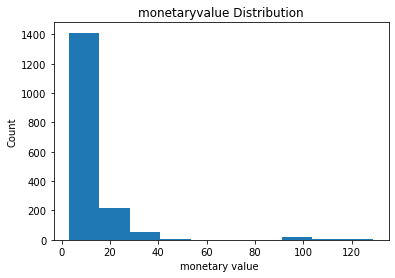

In [34]:
plt.hist(monetaryvalue['monetaryvalue'], bins=10)
plt.xlabel('monetary value ')
plt.ylabel('Count')
plt.title('monetaryvalue Distribution')
plt.show()

In [35]:
#Basetable with RFM metrics
basetable=basetable.merge(monetaryvalue, how='left', left_on='CustomerID', right_on='CustomerID')

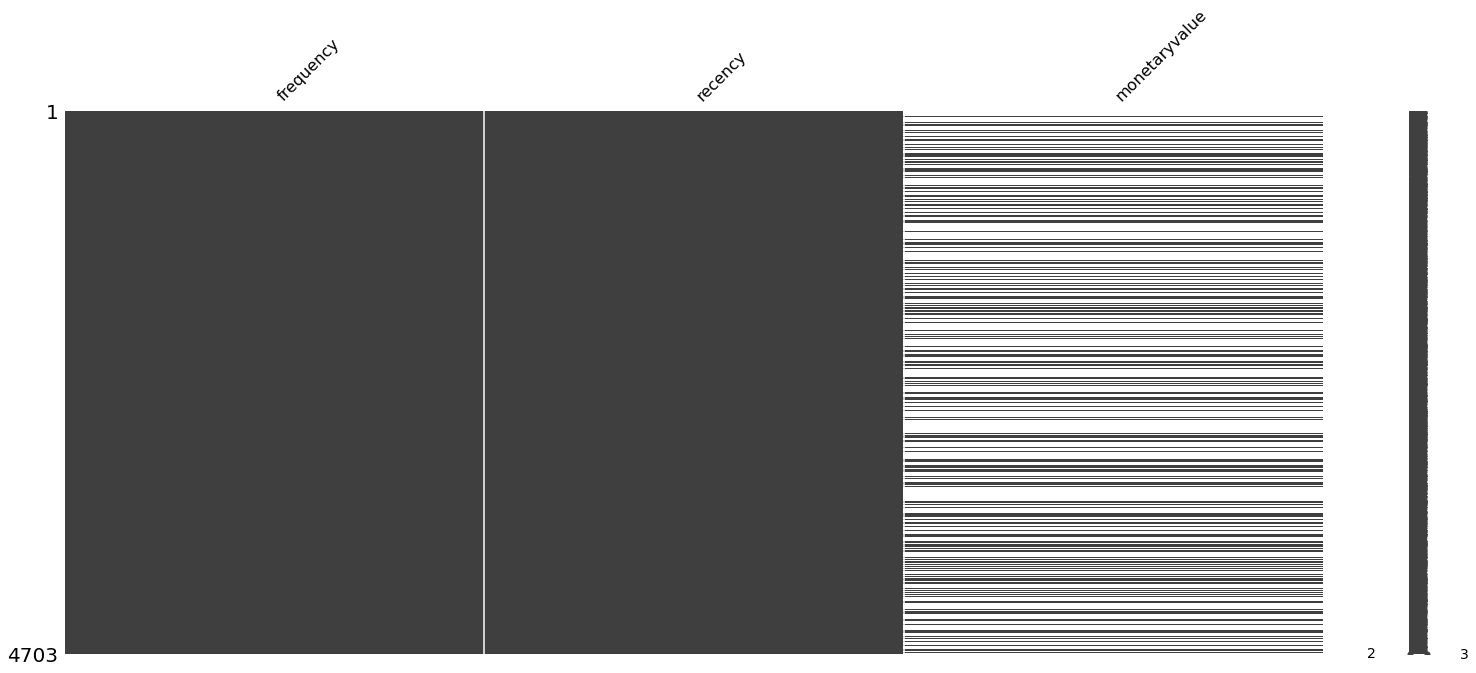

In [36]:
missingno.matrix(basetable)
plt.show()

In [37]:
basetable['monetaryvalue']=basetable['monetaryvalue'].fillna(0)
basetable

,frequency,recency,monetaryvalue
CustomerID,,,
1,3,35,0.00
2,1,54,0.00
3,3,25,0.00
4,4,7,0.00
5,1,44,19.97
...,...,...,...
4996,3,0,0.00
4997,1,31,9.99
4998,9,20,4.99


In [38]:
print(basetable.describe())

         frequency      recency  monetaryvalue
count  4703.000000  4703.000000    4703.000000
mean      4.274506    30.133744       3.995596
std       2.839781    28.478207      10.360940
min       1.000000     0.000000       0.000000
25%       2.000000     8.000000       0.000000
50%       4.000000    21.000000       0.000000
75%       6.000000    44.000000       4.990000
max      21.000000   122.000000     128.990000


In [39]:
basetable = summer.merge(basetable, how='left', left_on='CustomerID', right_on='CustomerID')
basetable=basetable.drop(['nbrsesstrx'],axis=1)
#basetable['Gender'] = basetable['Gender'].replace({0: 'male', 1: 'female'})
#basetable['CustomerType'] = basetable['CustomerType'].replace({1: 'walker', 2: 'miscellaneous',3:'social raider',4:'catcher'})
#basetable['Income'] = basetable['Income'].replace({1: 'low', 2: 'medium',3:'high'})
#basetable['fallbonus'] = basetable['fallbonus'].replace({0: 'no', 1: 'yes'})

In [40]:
basetable

,CustomerID,CustomerType,Registrationdate,Gender,Age,fallbonus,Income,frequency,recency,monetaryvalue
0,1,4,2021-09-30,1,8,0,1,3,35,0.00
1,2,4,2022-04-06,1,27,0,1,1,54,0.00
2,3,3,2020-05-24,0,7,0,2,3,25,0.00
3,4,4,2021-09-21,0,11,0,2,4,7,0.00
4,5,4,2021-07-08,1,16,1,1,1,44,19.97
...,...,...,...,...,...,...,...,...,...,...
4698,4996,1,2022-03-18,0,42,0,3,3,0,0.00
4699,4997,4,2022-04-02,1,30,1,2,1,31,9.99
4700,4998,3,2022-03-11,1,9,0,3,9,20,4.99
4701,4999,3,2022-04-28,0,30,1,2,10,25,0.00


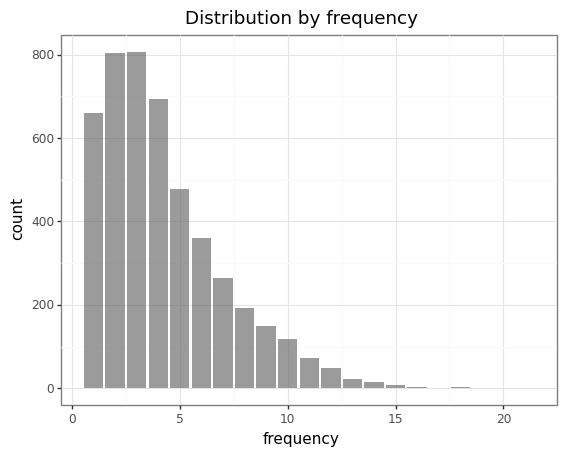

In [41]:
plot1=(ggplot(basetable, aes(x='frequency')) +
  theme_bw() +
  scale_x_continuous() +
  geom_bar(alpha=0.6) +  
  ggtitle("Distribution by frequency"))
print(plot1)

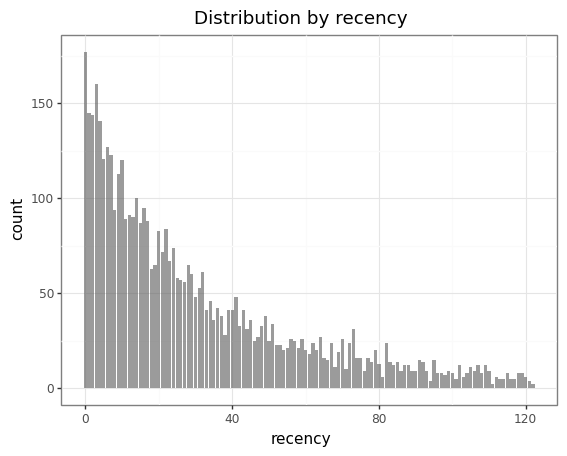

In [42]:
plot2=(ggplot(basetable, aes(x='recency')) +
  theme_bw() +
  geom_bar(alpha=0.6) +
  ggtitle("Distribution by recency"))
print(plot2)

## CLV Analysis

In [43]:
import pandas# working with datraframes
import datetime# working with dates
import statsmodels.api as sm
import statsmodels.formula.api as smf#used for fitting models
from joblib import Parallel, delayed
import multiprocessing
import time


In [44]:
#find purchase amount of customers
def func(x):
    if x == 1:
        return 2.99
    elif x == 2:
        return 4.99
    elif x == 3:
        return 9.99
    elif x == 4:
        return 25
    elif x == 5:
        return 99
    else:
        return 'N/A'

In [45]:
df1=summerfintrx
df1

,TransID,Date,CustomerID,ProductID,PurchaseAmount
0,1,2022-05-01,4147,2,4.99
1,2,2022-05-01,3065,2,4.99
2,3,2022-05-01,4078,1,2.99
3,4,2022-05-01,4850,1,2.99
4,5,2022-05-01,4806,4,25.00
...,...,...,...,...,...
2245,2246,2022-08-31,4774,3,9.99
2246,2247,2022-08-31,3909,4,25.00
2247,2248,2022-08-31,1508,3,9.99
2248,2249,2022-08-31,3484,1,2.99


In [46]:
fallfintrx['PurchaseAmount'] = summerfintrx['ProductID'].apply(func)
df2=fallfintrx
df2
#1826 microtransactions during the fall period 

,TransID,Date,CustomerID,ProductID,PurchaseAmount
0,1,2022-09-01,2,2,4.99
1,2,2022-09-01,5,2,4.99
2,3,2022-09-01,9,2,2.99
3,4,2022-09-01,10,1,2.99
4,5,2022-09-01,17,4,25.00
...,...,...,...,...,...
1821,1822,2022-12-31,1773,3,2.99
1822,1823,2022-12-31,1640,2,4.99
1823,1824,2022-12-31,2360,1,2.99
1824,1825,2022-12-31,3386,1,25.00


In [47]:
frames = [df1,df2]
df=pd.concat(frames)
df

,TransID,Date,CustomerID,ProductID,PurchaseAmount
0,1,2022-05-01,4147,2,4.99
1,2,2022-05-01,3065,2,4.99
2,3,2022-05-01,4078,1,2.99
3,4,2022-05-01,4850,1,2.99
4,5,2022-05-01,4806,4,25.00
...,...,...,...,...,...
1821,1822,2022-12-31,1773,3,2.99
1822,1823,2022-12-31,1640,2,4.99
1823,1824,2022-12-31,2360,1,2.99
1824,1825,2022-12-31,3386,1,25.00


In [48]:
startDate_summer=datetime.datetime.strptime('01/05/2022','%d/%m/%Y')
endDate_summer=datetime.datetime.strptime('31/08/2022','%d/%m/%Y')

In [49]:
startDate_fall=datetime.datetime.strptime('01/09/2022','%d/%m/%Y')
endDate_fall=datetime.datetime.strptime('31/12/2022','%d/%m/%Y')

In [50]:
def createbasetable(df, startDate, endDate):
    df=df[(df.Date>= startDate) & (df.Date<= endDate)]
    basetable=df.groupby('CustomerID',as_index=False).agg(frequency=('CustomerID','count'),
                              recency=('Date', lambda date: (endDate - date.max()).days),
                              monetaryvalue=('PurchaseAmount','sum')
                              )
    return basetable

In [51]:
summer=createbasetable(df,startDate_summer,endDate_summer)
fall=createbasetable(df,startDate_fall,endDate_fall)
complete=createbasetable(df,startDate_summer,endDate_fall)
fallid=fall.drop(['frequency','recency','monetaryvalue'],axis=1)
fallid['buy']=1
summer=summer.merge(fallid,how='left',left_on='CustomerID', right_on='CustomerID')
summer['buy']=summer['buy'].fillna(0)


In [52]:
averageretentionrate=sum(summer.buy)/summer.shape[0]
averageretentionrate
#average retention rate = 0.80

0.7995324371712449

In [53]:
####################################
# Part 2  CLV global retention     #
####################################

In [54]:
def calc_clv(margin, r, d, acquisition,t):
    clv=-acquisition
    for i in range(0,t+1):
         clv=clv+(pow(r,i)*margin)/(pow((1+d),i))
    return(clv)

In [55]:
#check if the function works, and we assume the margin per capita equals to 80,discount rate=0.03, t=4 years, acquisition fee=10
v=calc_clv(80,0.80,0.03,10,4)
v

246.99497883095205

In [56]:
summer['clv']=summer.apply(lambda X: calc_clv(X.monetaryvalue,0.80,0.03,10,4), axis=1)
summer['clv'].describe()

count    1711.000000
mean       25.281028
std        47.474303
min        -0.394813
25%        -0.394813
50%         6.030062
75%        22.092248
max       404.372279
Name: clv, dtype: float64

In [57]:
complete['clv']=complete.apply(lambda X: calc_clv(X.monetaryvalue,0.80,0.03,10,4), axis=1)
complete['clv'].describe()

count    2027.000000
mean       44.065128
std        60.431591
min        -0.394813
25%         9.210375
50%        22.092248
75%        57.316622
max       642.092634
Name: clv, dtype: float64

## Lifecycle grids

In [58]:
basetable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4703 entries, 0 to 4702
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        4703 non-null   int64         
 1   CustomerType      4703 non-null   int64         
 2   Registrationdate  4703 non-null   datetime64[ns]
 3   Gender            4703 non-null   int64         
 4   Age               4703 non-null   int64         
 5   fallbonus         4703 non-null   int64         
 6   Income            4703 non-null   int64         
 7   frequency         4703 non-null   int64         
 8   recency           4703 non-null   int64         
 9   monetaryvalue     4703 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(8)
memory usage: 404.2 KB


In [59]:
#Create dummy variable for in-game purchase
basetable['purchasedummy'] = basetable['monetaryvalue'].apply(lambda x: 0 if x ==0.00 else 1)
#0 represents not pay for in-game product, otherwise is 1

In [60]:
basetable

,CustomerID,CustomerType,Registrationdate,Gender,Age,fallbonus,Income,frequency,recency,monetaryvalue,purchasedummy
0,1,4,2021-09-30,1,8,0,1,3,35,0.00,0
1,2,4,2022-04-06,1,27,0,1,1,54,0.00,0
2,3,3,2020-05-24,0,7,0,2,3,25,0.00,0
3,4,4,2021-09-21,0,11,0,2,4,7,0.00,0
4,5,4,2021-07-08,1,16,1,1,1,44,19.97,1
...,...,...,...,...,...,...,...,...,...,...,...
4698,4996,1,2022-03-18,0,42,0,3,3,0,0.00,0
4699,4997,4,2022-04-02,1,30,1,2,1,31,9.99,1
4700,4998,3,2022-03-11,1,9,0,3,9,20,4.99,1
4701,4999,3,2022-04-28,0,30,1,2,10,25,0.00,0


In [61]:
customersegm=basetable.assign(
    segmfreq=lambda x: pd.cut(basetable['frequency'], 
                                              bins=[0,1,2,3,4,5,99],
                                              labels=["1", "2", "3",'4','5','>5']),
    segmrec=lambda x: pd.cut(basetable['recency'], 
                                              bins=[0,6,13,19,45,80,120],
                                              labels=["0-6 days", "7-13 days", "14-19 days",'20-45 days','46-80 days','>80 days']))

In [62]:
customersegm['segmfreq']=pd.Categorical(customersegm['segmfreq'], categories=[">5","5", "4", "3","2","1"])
customersegm['segmrec']=pd.Categorical(customersegm['segmrec'], categories=[">80 days","46-80 days", "20-45 days", "14-19 days","7-13 days","0-6 days"])

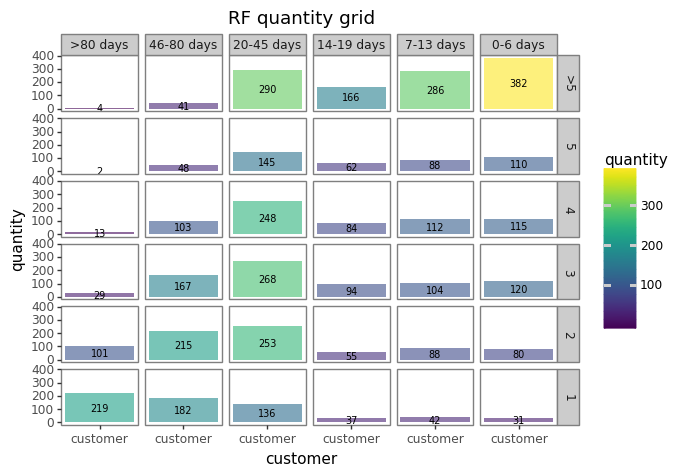

In [63]:
# Lifecycle grid with customer RF quantity 
lcg=customersegm.groupby(['segmfreq','segmrec'],observed=True, as_index=False).agg(quantity=('CustomerID','count'))
lcg['customer']='customer'

plot3=(ggplot(lcg, aes(x='customer', y='quantity',fill='quantity'))+#xvalue is the client factor that is the same for all y values
  #xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  #removes colored boxed behind bar chart
  geom_bar(stat='identity', alpha=0.6) +#stat="identity bar chart based on y value, alpha controls transparency
  #stat="identity because y is a variable in the dataset scale makes the fill transparent
  geom_text(aes(y='quantity/2', label='quantity'), size=7) +#display the quantity label at the top of the bar
  #display the quantity at 50% of the height of the bar
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
  #organises the bar chart around the r & f variables
  ggtitle("RF quantity grid"))
print(plot3)

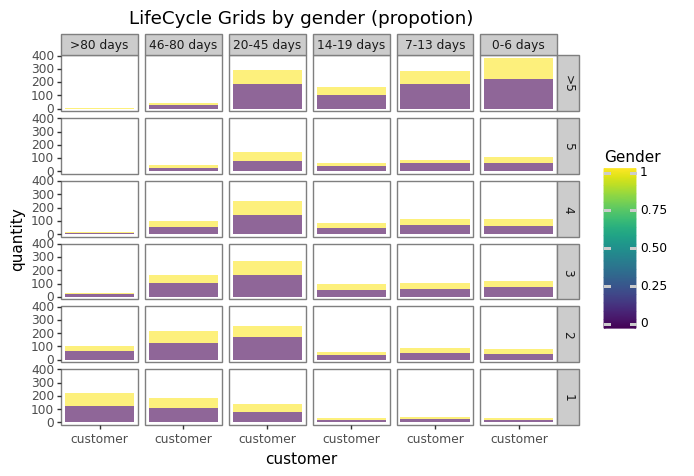

In [64]:
#Lifecycle grid by customer gender propotion
lcg2=customersegm.groupby(['Gender','segmfreq','segmrec'],observed=True, as_index=False).agg(quantity=('CustomerID','count'))
lcg2['customer']='customer'

plot4=(ggplot(lcg2, aes(x='customer', y='quantity',fill='Gender'))+#xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  geom_bar(stat='identity',alpha=0.6) +  #position=fill will force ggplot to use the whole grid, if you want to use geom_text make sure the location is between 0 and 1
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
 ggtitle("LifeCycle Grids by gender (propotion)"))
print(plot4)

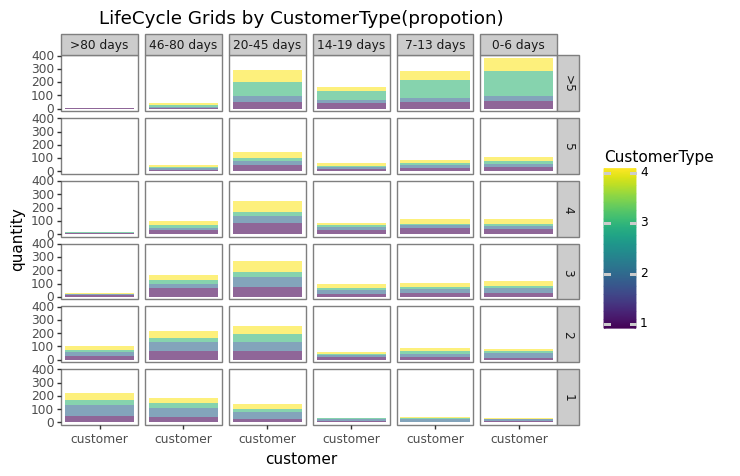

In [65]:
#Lifecycle grid by customer type propotion
lcg3=customersegm.groupby(['CustomerType','segmfreq','segmrec'],observed=True, as_index=False).agg(quantity=('CustomerID','count'))
lcg3['customer']='customer'

plot5=(ggplot(lcg3, aes(x='customer', y='quantity',fill='CustomerType'))+#xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  geom_bar(stat='identity',alpha=0.6) +  #position=fill will force ggplot to use the whole grid, if you want to use geom_text make sure the location is between 0 and 1
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
 ggtitle("LifeCycle Grids by CustomerType(propotion)"))
print(plot5)

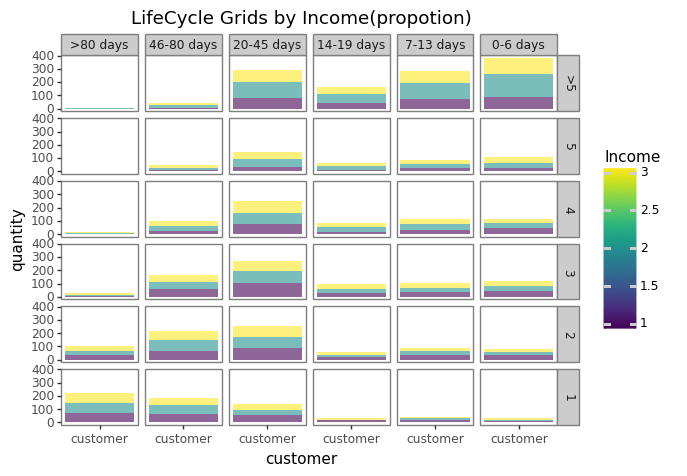

In [66]:
#Lifecycle grid by customer income propotion
lcg4=customersegm.groupby(['Income','segmfreq','segmrec'],observed=True, as_index=False).agg(quantity=('CustomerID','count'))
lcg4['customer']='customer'

plot6=(ggplot(lcg4, aes(x='customer', y='quantity',fill='Income'))+#xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  geom_bar(stat='identity', alpha=0.6) +  #position=fill will force ggplot to use the whole grid, if you want to use geom_text make sure the location is between 0 and 1
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
 ggtitle("LifeCycle Grids by Income(propotion)"))
print(plot6)

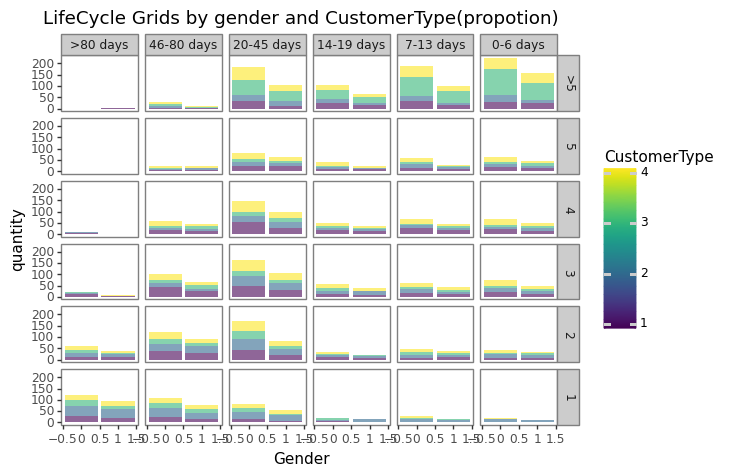

In [67]:
#Lifecycle grid by customer gender and customer type propotion
lcg5=customersegm.groupby(['Gender','CustomerType','segmfreq','segmrec'],observed=True, as_index=False).agg(quantity=('CustomerID','count'))
lcg5['customer']='customer'
        
plot6=(ggplot(lcg5, aes(x='Gender', y='quantity',fill='CustomerType'))+#xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  geom_bar(stat='identity', alpha=0.6) +#stat="identity bar chart based on y value, alpha controls transparency
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
 ggtitle("LifeCycle Grids by gender and CustomerType(propotion)"))
print(plot6)

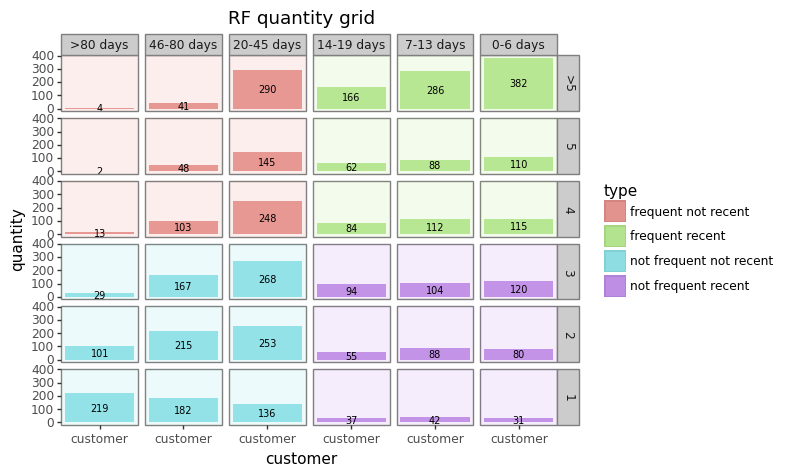

In [68]:
lcg['type']=''
reclist = ["14-19 days","7-13 days","0-6 days"]
freqlist =[">5","5","4"]
lcg['type']=lcg.apply(lambda X:X.type+'frequent' if X.segmfreq in freqlist else X.type+'not frequent', axis=1)
lcg['type']=lcg.apply(lambda X:X.type+' recent' if X.segmrec in reclist else X.type+' not recent', axis=1)

plot8=(ggplot(lcg, aes(x='customer', y='quantity',fill='type'))+#xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  geom_rect(aes(fill = 'type'), xmin = -float("inf"), xmax = float("inf"), ymin = -float("inf"), ymax = float("inf"), alpha = 0.1) +#background based on type
  geom_bar(stat='identity', alpha=0.6) +#stat="identity bar chart based on y value, alpha controls transparency
  geom_text(aes(y='quantity/2', label='quantity'), size=7) +#display the quantity label at the top of the bar
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
 ggtitle("RF quantity grid"))
print(plot8)

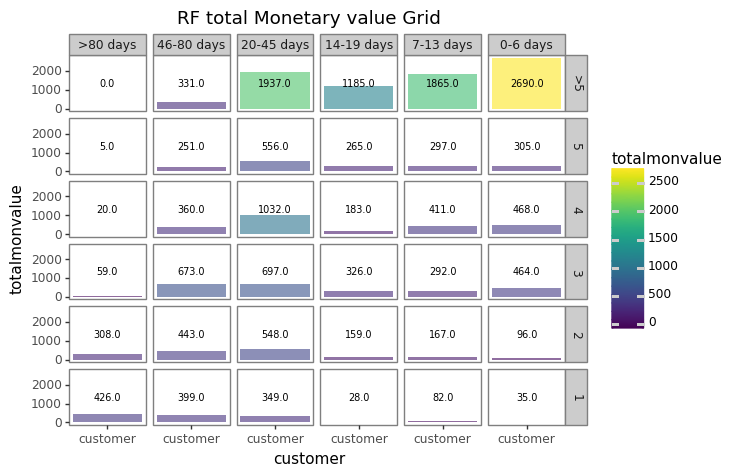

In [69]:
#Lifecycle grid with Monetary value
lcgmon=customersegm.groupby(['segmfreq','segmrec'],observed=True, as_index=False).agg(totalmonvalue=('monetaryvalue','sum'))
lcgmon['customer']='customer'

plot9=(ggplot(lcgmon, aes(x='customer', y='totalmonvalue',fill='totalmonvalue'))+#xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  geom_bar(stat='identity', alpha=0.6) +#stat="identity bar chart based on y value, alpha controls transparency
  geom_text(aes(y='np.nanmax(totalmonvalue)/2', label='np.ceil(totalmonvalue)'), size=7) +#display the quantity label at 50% of the height of the bar
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
 ggtitle("RF total Monetary value Grid"))
print(plot9) 

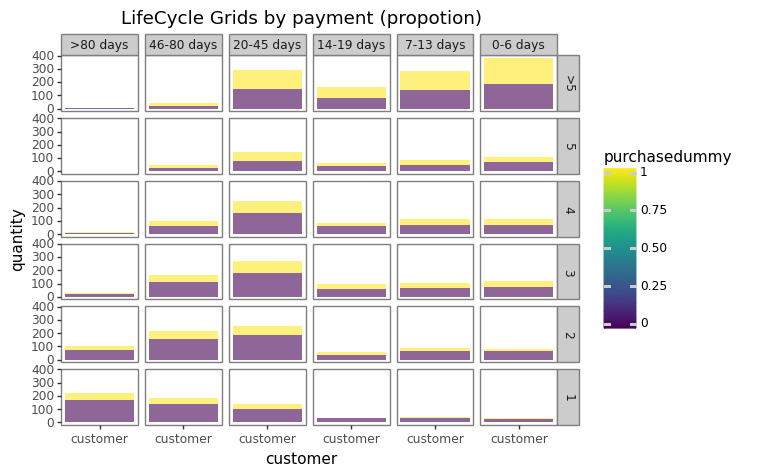

In [70]:
#Lifecycle grid with in-game purchase 
lcgpur=customersegm.groupby(['purchasedummy','segmfreq','segmrec'],observed=True, as_index=False).agg(quantity=('CustomerID','count'))
lcgpur['customer']='customer'

plot10=(ggplot(lcgpur, aes(x='customer', y='quantity',fill='purchasedummy'))+#xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  geom_bar(stat='identity', alpha=0.6) +  #position=fill will force ggplot to use the whole grid, if you want to use geom_text make sure the location is between 0 and 1
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
 ggtitle("LifeCycle Grids by payment (propotion)"))
print(plot10)

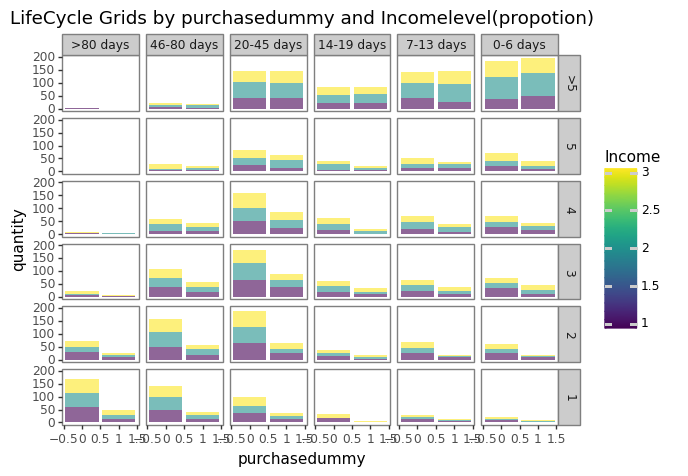

In [71]:
#Lifecycle grid by in-game purchase and income propotion
lcg6=customersegm.groupby(['purchasedummy','Income','segmfreq','segmrec'],observed=True, as_index=False).agg(quantity=('CustomerID','count'))
lcg6['customer']='customer'
        
plot12=(ggplot(lcg6, aes(x='purchasedummy', y='quantity',fill='Income'))+#xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  geom_bar(stat='identity', alpha=0.6) +#stat="identity bar chart based on y value, alpha controls transparency
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
 ggtitle("LifeCycle Grids by purchasedummy and Incomelevel(propotion)"))
print(plot12)

## Churn analysis

In [72]:
fallfintrx_customerid_list = fallfintrx['CustomerID'].to_list()
summerfintrx['churn'] = summerfintrx['CustomerID'].apply(lambda x: 0 if x in fallfintrx_customerid_list else 1)

In [73]:
summerfintrx

,TransID,Date,CustomerID,ProductID,PurchaseAmount,churn
0,1,2022-05-01,4147,2,4.99,0
1,2,2022-05-01,3065,2,4.99,0
2,3,2022-05-01,4078,1,2.99,0
3,4,2022-05-01,4850,1,2.99,0
4,5,2022-05-01,4806,4,25.00,0
...,...,...,...,...,...,...
2245,2246,2022-08-31,4774,3,9.99,0
2246,2247,2022-08-31,3909,4,25.00,0
2247,2248,2022-08-31,1508,3,9.99,0
2248,2249,2022-08-31,3484,1,2.99,0


In [74]:
churn=summerfintrx.groupby('CustomerID').agg({'CustomerID':'count',
                                         'Date':lambda date: (endtime - date.max()).days,
                                         'PurchaseAmount': 'sum','churn':'max'
                                         })
churn

,CustomerID,Date,PurchaseAmount,churn
CustomerID,,,,
5,3,9,19.97,0
9,1,115,4.99,0
10,1,23,4.99,0
17,1,39,4.99,0
20,1,60,2.99,0
...,...,...,...,...
4988,1,89,2.99,0
4989,1,5,4.99,0
4997,1,73,9.99,0


In [75]:
churn.columns=['pfrequency','precency','PurchaseAmount','churn']
churn

,pfrequency,precency,PurchaseAmount,churn
CustomerID,,,,
5,3,9,19.97,0
9,1,115,4.99,0
10,1,23,4.99,0
17,1,39,4.99,0
20,1,60,2.99,0
...,...,...,...,...
4988,1,89,2.99,0
4989,1,5,4.99,0
4997,1,73,9.99,0


In [76]:
basetable = basetable.merge(churn, how='right', left_on='CustomerID', right_on='CustomerID')
basetable=basetable.drop(['purchasedummy'],axis=1)
basetable=basetable.drop(['PurchaseAmount'],axis=1)

In [77]:
basetable

,CustomerID,CustomerType,Registrationdate,Gender,Age,fallbonus,Income,frequency,recency,monetaryvalue,pfrequency,precency,churn
0,5,4,2021-07-08,1,16,1,1,1,44,19.97,3,9,0
1,9,1,2016-10-22,1,34,0,2,7,1,4.99,1,115,0
2,10,1,2019-01-17,0,17,0,3,9,8,4.99,1,23,0
3,17,2,2022-02-23,1,12,0,3,4,24,4.99,1,39,0
4,20,1,2022-02-24,0,9,1,3,5,5,2.99,1,60,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1706,4988,4,2022-04-11,1,17,1,3,3,21,2.99,1,89,0
1707,4989,2,2021-08-14,1,30,1,3,6,5,4.99,1,5,0
1708,4997,4,2022-04-02,1,30,1,2,1,31,9.99,1,73,0
1709,4998,3,2022-03-11,1,9,0,3,9,20,4.99,1,15,0


In [78]:
grouped_ct = basetable.groupby('CustomerType').size()

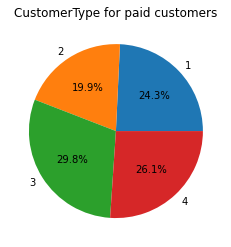

In [79]:
fig, ax = plt.subplots()
ax.pie(grouped_ct.values, labels=grouped_ct.index, autopct='%1.1f%%')
ax.set_title('CustomerType for paid customers')

plt.show()

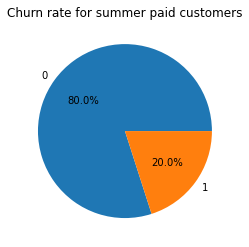

In [88]:
churncustomer = basetable.groupby('churn').size()
fig, ax = plt.subplots()
ax.pie(churncustomer.values, labels=churncustomer.index, autopct='%1.1f%%')
ax.set_title('Churn rate for summer paid customers')
plt.show()

In [80]:
churn_number=sum(basetable.churn)
churn_number

343

In [81]:
basetable_churn = basetable[basetable['churn'] == 1]
basetable_churn

,CustomerID,CustomerType,Registrationdate,Gender,Age,fallbonus,Income,frequency,recency,monetaryvalue,pfrequency,precency,churn
6,25,3,2022-03-19,0,41,0,2,8,43,14.98,2,24,1
7,27,3,2022-03-23,1,37,1,3,12,0,5.98,2,52,1
9,31,4,2020-01-25,1,23,0,1,8,3,19.97,3,8,1
29,112,2,2022-02-01,0,28,0,3,1,29,2.99,1,88,1
33,120,3,2022-04-12,1,22,0,3,16,7,9.98,2,46,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1685,4911,1,2022-01-15,0,34,0,1,3,37,4.99,1,44,1
1693,4940,4,2019-10-14,1,27,0,1,5,13,4.99,1,14,1
1702,4970,3,2018-10-01,0,22,1,2,3,43,4.99,1,100,1
1705,4981,3,2016-12-06,1,43,0,1,3,80,25.00,1,6,1


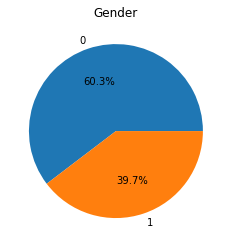

In [82]:
gender = basetable_churn.groupby('Gender').size()
fig, ax = plt.subplots()
ax.pie(gender.values, labels=gender.index, autopct='%1.1f%%')
ax.set_title('Gender')

plt.show()

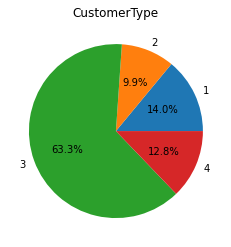

In [83]:
ct = basetable_churn.groupby('CustomerType').size()
fig, ax = plt.subplots()
ax.pie(ct.values, labels=ct.index, autopct='%1.1f%%')
ax.set_title('CustomerType')

plt.show()

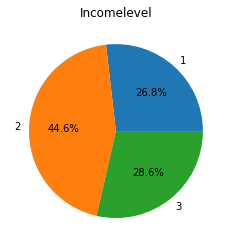

In [84]:
income = basetable_churn.groupby('Income').size()
fig, ax = plt.subplots()
ax.pie(income.values, labels=income.index, autopct='%1.1f%%')
ax.set_title('Incomelevel')

plt.show()

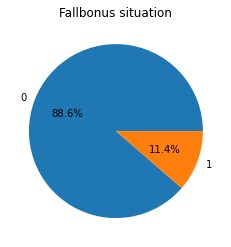

In [87]:
fallbonus = basetable_churn.groupby('fallbonus').size()
fig, ax = plt.subplots()
ax.pie(fallbonus.values, labels=fallbonus.index, autopct='%1.1f%%')
ax.set_title('Fallbonus situation')

plt.show()

In [2063]:
train, test = train_test_split(basetable, test_size=0.3,random_state=1)

<AxesSubplot:>

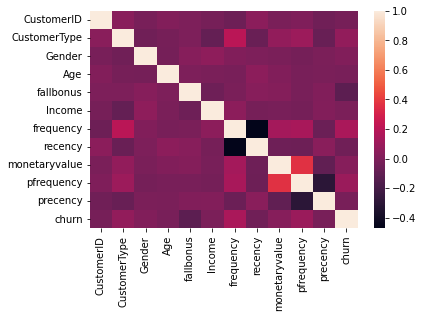

In [2064]:
#Exploratory analysis
corrmatrixtrain=train.corr()
corrmatrixtest=test.corr()
sns.heatmap(train.corr())

In [2065]:
logit_mod = smf.logit(formula='churn ~ CustomerType+Gender+Age+fallbonus+Income+frequency+recency+monetaryvalue+pfrequency+precency', data=train)
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.485971
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                 1197
Model:                          Logit   Df Residuals:                     1186
Method:                           MLE   Df Model:                           10
Date:                Mon, 20 Feb 2023   Pseudo R-squ.:                 0.04327
Time:                        01:15:06   Log-Likelihood:                -581.71
converged:                       True   LL-Null:                       -608.02
Covariance Type:            nonrobust   LLR p-value:                 8.749e-08
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.3698      0.444     -5.333      0.000      -3.241      -1.499
CustomerType      0.

In [2066]:
X=train[['CustomerType','Gender','Age','fallbonus','Income','frequency','recency','monetaryvalue','pfrequency','precency']]
Y=train['churn']
forward=forwardSelection(X, Y,model_type ="logistic",elimination_criteria = "aic", varchar_process = "dummy_dropfirst", sl=0.05)
forward[2].summary()

Optimization terminated successfully.
         Current function value: 0.507952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.505913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.507901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.507772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.499717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.497992
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.507630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.503646
  

/var/folders/kv/l_snhqmn5jv_10sfp3nr2ycr0000gn/T/ipykernel_24198/645460517.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/var/folders/kv/l_snhqmn5jv_10sfp3nr2ycr0000gn/T/ipykernel_24198/645460517.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/var/folders/kv/l_snhqmn5jv_10sfp3nr2ycr0000gn/T/ipykernel_24198/645460517.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/var/folders/kv/l_snhqmn5jv_10sfp3nr2ycr0000gn/T/ipykernel_24198/645460517.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/var/folders/kv/l_snhqmn5jv_10sfp3nr2ycr0000gn/T/ipykernel_24198/645460517.py:100: FutureWarning: The frame.append method is deprecated 

Optimization terminated successfully.
         Current function value: 0.489921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.497836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.497962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.489921
         Iterations 6
Entered : fallbonus 	AIC : 1178.8707275624638
Optimization terminated successfully.
         Current function value: 0.489262
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489834
         Iterations 6
Optimization terminated successfully

/var/folders/kv/l_snhqmn5jv_10sfp3nr2ycr0000gn/T/ipykernel_24198/645460517.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/var/folders/kv/l_snhqmn5jv_10sfp3nr2ycr0000gn/T/ipykernel_24198/645460517.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/var/folders/kv/l_snhqmn5jv_10sfp3nr2ycr0000gn/T/ipykernel_24198/645460517.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/var/folders/kv/l_snhqmn5jv_10sfp3nr2ycr0000gn/T/ipykernel_24198/645460517.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/var/folders/kv/l_snhqmn5jv_10sfp3nr2ycr0000gn/T/ipykernel_24198/645460517.py:100: FutureWarning: The frame.append method is deprecated 

Optimization terminated successfully.
         Current function value: 0.489863
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487353
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487353
         Iterations 6
Entered : pfrequency 	AIC : 1174.7242589864745
Optimization terminated successfully.
         Current function value: 0.486891
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487224
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487176
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487121
         Iterations 6
Optimization terminated successfull

/var/folders/kv/l_snhqmn5jv_10sfp3nr2ycr0000gn/T/ipykernel_24198/645460517.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/var/folders/kv/l_snhqmn5jv_10sfp3nr2ycr0000gn/T/ipykernel_24198/645460517.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/var/folders/kv/l_snhqmn5jv_10sfp3nr2ycr0000gn/T/ipykernel_24198/645460517.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/var/folders/kv/l_snhqmn5jv_10sfp3nr2ycr0000gn/T/ipykernel_24198/645460517.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/var/folders/kv/l_snhqmn5jv_10sfp3nr2ycr0000gn/T/ipykernel_24198/645460517.py:100: FutureWarning: The frame.append method is deprecated 

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                 1197
Model:                          Logit   Df Residuals:                     1193
Method:                           MLE   Df Model:                            3
Date:                Mon, 20 Feb 2023   Pseudo R-squ.:                 0.04055
Time:                        01:15:06   Log-Likelihood:                -583.36
converged:                       True   LL-Null:                       -608.02
Covariance Type:            nonrobust   LLR p-value:                 1.119e-10
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.1427      0.206    -10.423      0.000      -2.546      -1.740
frequency      0.1027      0.023      4.480      0.000       0.058       0.148
fallbonus     -0.8749      0.217     -4.037      0.000      -1.300      -0.450
pfrequency     0.2862      0.114      2.519      0.012       0.064       0.509
==============================================================================
"""

In [2067]:
Xtrain=train[np.intersect1d(train.columns,forward[0])]#only select var retained from backbward selection
Xtrain=Xtrain.reindex(columns=forward[0])#sort them according to the sequence used in the regression
Xtrain['intercept']=1#add constant variable
train['predict']=forward[2].predict(Xtrain)#store prediction in corresponding dataset

Xtest=test[np.intersect1d(test.columns,forward[0])]#only select var retained from backbward selection
Xtest=Xtest.reindex(columns=forward[0])#sort them according to the sequence used in the regression
Xtest['intercept']=1#add constant variable
test['predict']=forward[2].predict(Xtest)#store prediction in corresponding dataset

Cutoff used:  0.5
          Predicted 0  Predicted 1
Actual 0          951            0
Actual 1          242            4
Accuracy Score :  79.78
ROC AUC score :  62.46
Precision score :  100.0
sensitivity score :  1.63
specificity score :  100.0


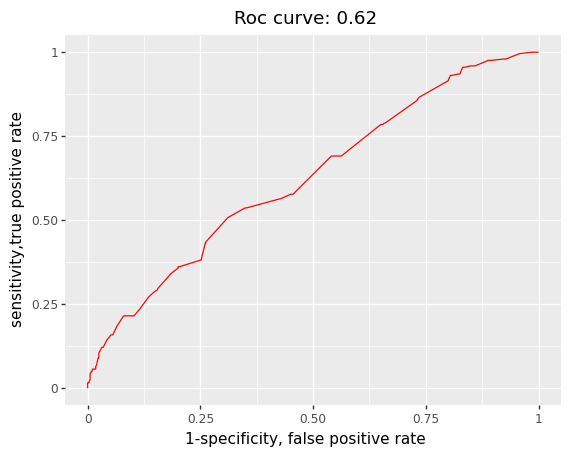


Cutoff used:  0.5
          Predicted 0  Predicted 1
Actual 0          415            2
Actual 1           96            1
Accuracy Score :  80.93
ROC AUC score :  63.44
Precision score :  33.33
sensitivity score :  1.03
specificity score :  99.52


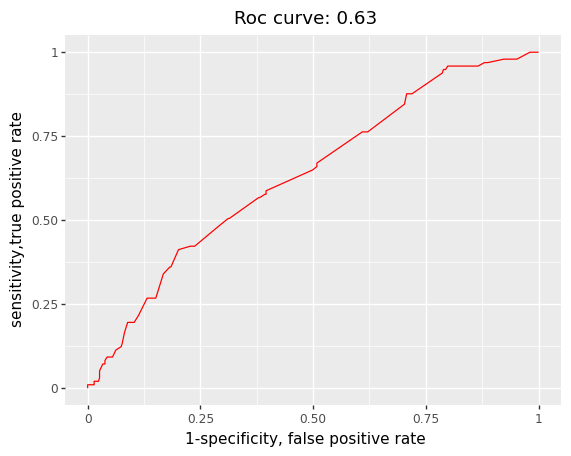

In [2068]:
#confusion matrix related performance measures
def evaluate_model(actual, pred,cutoff=0.5):
    #confusion matrix
    cm_df = pd.DataFrame(confusion_matrix(actual,pred>cutoff))
    cm_df.columns = ['Predicted 0', 'Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    print("Cutoff used: ",cutoff)
    print(cm_df)
    # Accuracy Score
    acc_score = round(accuracy_score(actual, pred>cutoff)*100,2)
    print('Accuracy Score : ',acc_score)
    # ROC AUC score
    roc_score = round(roc_auc_score(actual, pred)*100,2)
    print('ROC AUC score : ',roc_score)
    # Precision score
    prec_score = round(precision_score(actual, pred>cutoff)*100,2)
    print('Precision score : ', prec_score)
    # Recall score
    sens_score = round(recall_score(actual, pred>cutoff)*100,2)#recall=sensitivity
    print('sensitivity score : ', sens_score)
    tn, fp, fn, tp = confusion_matrix(actual,pred>cutoff).ravel()
    spec_score = round((tn / (tn + fp))*100,2)
    print('specificity score : ', spec_score)
    fpr, tpr, _ = roc_curve(actual,pred)
    auc = roc_auc_score(actual,pred)
    roccurve=(pn.ggplot(pn.aes(x=fpr,y=tpr))+
                 pn.geom_line(color='red')+
                 pn.scale_y_continuous(name='sensitivity,true positive rate' ) +
                 pn.scale_x_continuous(name='1-specificity, false positive rate' ) +
                 pn.ggtitle('Roc curve: '+str(np.round(auc,2))))
    print(roccurve)
    return acc_score, roc_score, prec_score, sens_score, spec_score

performance=evaluate_model(train['churn'],train['predict'])
performance=evaluate_model(test['churn'],test['predict'])

In [2069]:
print('percentage churn in train dataset: ',np.round(np.mean(train['churn'])*100,2))
print('percentage churn in test dataset: ',np.round(np.mean(test['churn'])*100,2))

percentage churn in train dataset:  20.55
percentage churn in test dataset:  18.87


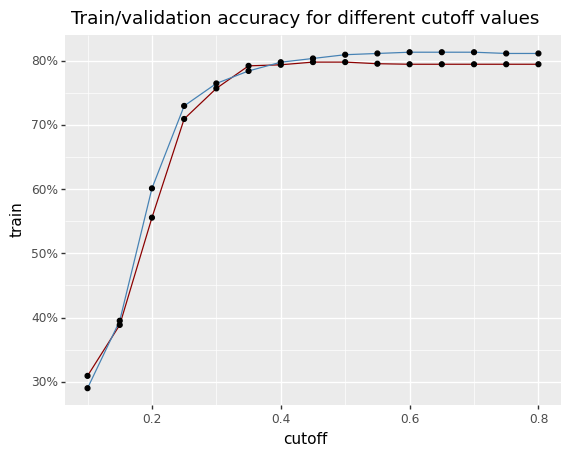

In [2070]:
def AccuracyCutoffInfo(training,validation,depvar='churn',pred='predict'):
    # change the cutoff value's range as you please
    cutoff=np.arange(0.1, 0.85, 0.05)
    cm_train=[0]*len(cutoff)
    cm_validation=[0]*len(cutoff)
    for i in range(0,len(cutoff)):  
        cm_train[i]=accuracy_score(training[depvar], training[pred]>cutoff[i])
        cm_validation[i]=accuracy_score(validation[depvar], validation[pred]>cutoff[i])
    accuracytable=pd.concat([pd.Series(cutoff).rename('cutoff'),pd.Series(cm_train).rename('train'),pd.Series(cm_validation).rename('validation')],axis=1)    
    accplot=(pn.ggplot(accuracytable, pn.aes(x='cutoff')) + 
    pn.geom_line( pn.aes(y = 'train'), color = "darkred")+
    pn.geom_line( pn.aes(y = 'validation'), color = "steelblue")+
    pn.geom_point(pn.aes(y = 'train'))+
    pn.geom_point(pn.aes(y = 'validation'))+
    pn.scale_y_continuous( labels=percent_format() ) +
    pn.ggtitle( "Train/validation accuracy for different cutoff values" ))
    print(accplot) 
  
AccuracyCutoffInfo(train,test,depvar='churn',pred='predict')

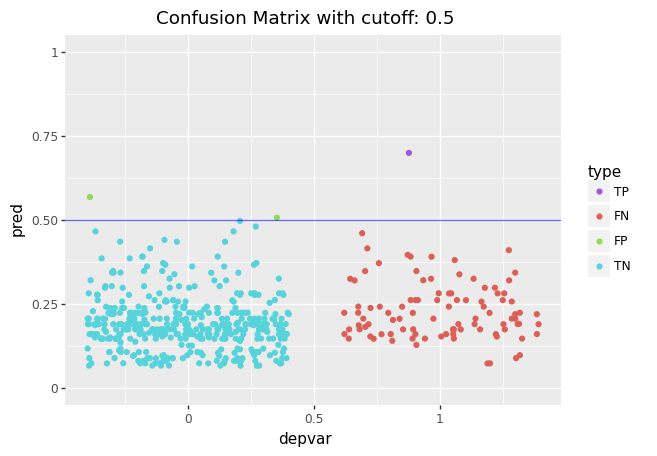

In [2071]:
def confusionmatrixplot(depvar,pred,cutoff=0.5):
    df=pd.concat([pd.Series(depvar).rename('depvar'),pd.Series(pred).rename('pred')],axis=1)
    def categorize(depvar,pred,cutoff):
        if (pred>=cutoff and depvar==1):
            return 'TP'
        elif (pred>=cutoff and depvar==0):
            return 'FP'
        elif(pred<cutoff and depvar==1):
            return 'FN'
        else:
            return 'TN'
    df['type']=df.apply(lambda X: categorize(X.depvar,X.pred,cutoff), axis=1)
    #plot table
    confusionplot= (pn.ggplot(df, pn.aes(x='depvar',y='pred', color = 'type' ) ) + 
        pn.geom_jitter() + 
        pn.geom_hline( yintercept = cutoff, color = "blue", alpha = 0.6 ) + 
        pn.scale_y_continuous( limits = (0.0,1.0) ) + 
        pn.scale_color_discrete( breaks = [ "TP", "FN", "FP", "TN" ] ) + # ordering of the legend 
        pn.guides( col = pn.guide_legend( nrow = 2 ) ) + # adjust the legend to have two rows  
        pn.ggtitle("Confusion Matrix with cutoff: "+str(cutoff)))
    print(confusionplot)

confusionmatrixplot(test['churn'],test['predict'],cutoff=0.5)

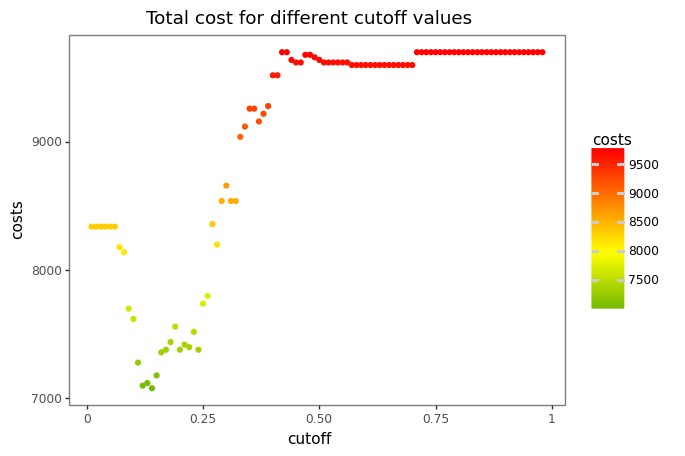


best cutoff:  0.14


In [2072]:
def findoptcutoff(depvar,pred):
    cutoff=np.arange(0.01, 0.99, 0.01)
    cost_fp=20#providing a discount to a non churner
    cost_fn=100#not identifying a churner and missing out on his clv
    costs=[0]*len(cutoff)
    bestcost=sys.maxsize
    bestindex=0 
    for i in range(0,len(cutoff)): 
        cm_df = pd.DataFrame(confusion_matrix(depvar,pred>cutoff[i]))
        am_fp=cm_df[1][0]
        am_fn=cm_df[0][1]
        costs[i]=am_fp*cost_fp+am_fn*cost_fn
        if(costs[i]<bestcost):
            bestcost=costs[i]
            bestindex=i       
    cutofftable=pd.concat([pd.Series(cutoff).rename('cutoff'),pd.Series(costs).rename('costs')],axis=1)
    cutoffchart=(pn.ggplot(cutofftable, pn.aes(x = 'cutoff', y = 'costs',color='costs'))+
       pn.theme_bw() +
       pn.theme(panel_grid = pn.element_blank())+
       pn.geom_point()+
       pn.scale_colour_gradient2(low = "green", high = "red", mid = "yellow",midpoint=8000)+
      pn. ggtitle("Total cost for different cutoff values"))
    print(cutoffchart)
    print('best cutoff: ', cutoff[bestindex])
    return cutoff[bestindex]

optcutoff=findoptcutoff(test['churn'],test['predict'])

Cutoff used:  0.14
          Predicted 0  Predicted 1
Actual 0           88          329
Actual 1            5           92
Accuracy Score :  35.02
ROC AUC score :  63.44
Precision score :  21.85
sensitivity score :  94.85
specificity score :  21.1


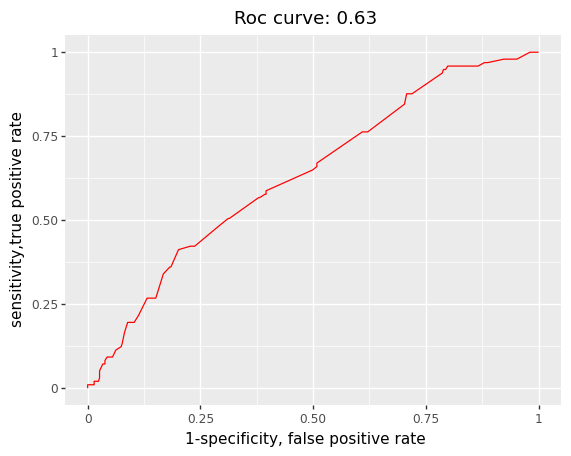

In [2073]:
performance=evaluate_model(test['churn'],test['predict'],cutoff=optcutoff)

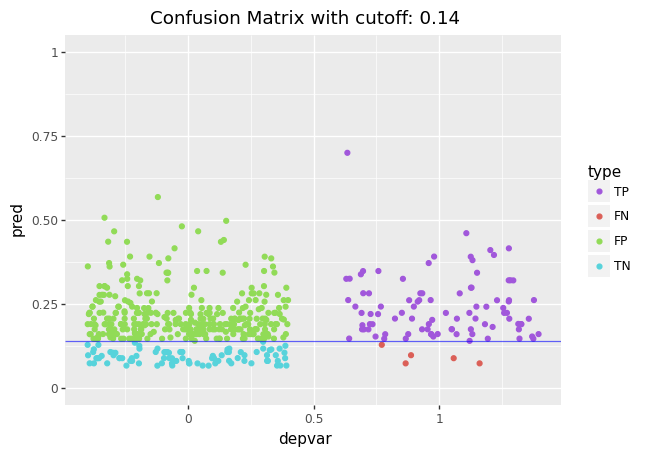

In [2074]:
confusionmatrixplot(test['churn'],test['predict'],cutoff=optcutoff)

/Users/yudilin/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:321: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


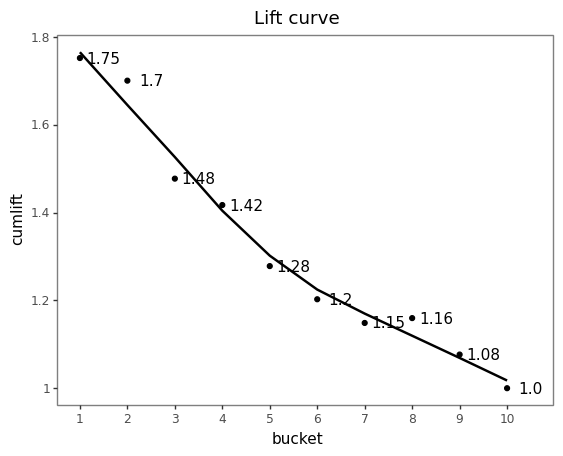

In [2075]:
#decile/lift table and chart
def calc_lift(depvar,pred,groups=10):
        helper=pd.concat([pd.Series(depvar).rename('depvar'),pd.Series(pred).rename('pred')],axis=1)
        #reverse sort dataset based on pred
        helper=helper.sort_values(by=['pred'],ascending=False)
        helper['id']=range(0,len(helper['depvar']))
        #create new bucket variable highest pred in bucket 1
        helper['bucket']=pd.qcut(helper['id'],q=10,labels=range(1, 10+1))
        #convert categorical bucket variable into a numeric one
        helper['bucket']=pd.to_numeric(helper['bucket'])
        #create gaintable: count number of churners per bucket and total customers in a bucket
        lifttable=helper.groupby("bucket", as_index=False).agg(total=('depvar','count'),totalresp=('depvar','sum'))
        #calculate cumulative number of churners
        lifttable['cumresp']=lifttable['totalresp'].cumsum()
        #calculate lift: how many churners did you catch out of the total number of customers in a bucket
        lifttable['lift']=lifttable['cumresp']/sum(lifttable['totalresp'])*100
        #calculate cumulative lift
        lifttable['cumlift']=lifttable['lift']/(lifttable['bucket']*(100/groups))
        return lifttable
    

    
def plot_liftchart(depvar,pred):
    lifttable=calc_lift(depvar,pred)
    liftchart=(pn.ggplot(lifttable, pn.aes(x = 'bucket', y = 'cumlift'))+
      pn.theme_bw() +
      pn.theme(panel_grid = pn.element_blank())+#removes colored box behind bar chart
      pn.scale_x_continuous(breaks=range(1,11)) +
      pn.geom_point()+
      pn.geom_smooth()+
      pn.geom_text(pn.aes(x='bucket+0.5',y='cumlift', label='np.round(cumlift,2)')) +
      pn.ggtitle("Lift curve"))
    print(liftchart)
    return lifttable 
    
lifttabletest=plot_liftchart(test['churn'],test['predict'])  

In [2076]:
lifttabletest

,bucket,total,totalresp,cumresp,lift,cumlift
0,1,52,17,17,17.525773,1.752577
1,2,51,16,33,34.020619,1.701031
2,3,51,10,43,44.329897,1.477663
3,4,52,12,55,56.701031,1.417526
4,5,51,7,62,63.917526,1.278351
5,6,51,8,70,72.164948,1.202749
6,7,52,8,78,80.412371,1.148748
7,8,51,12,90,92.783505,1.159794
8,9,51,4,94,96.907216,1.076747
9,10,52,3,97,100.000000,1.000000
